# Setpoint Reinforcement Learning
*Target a score for generalized control*

---

L’apprentissage par renforcement à permis de grande avancée dans le domaine du contrôle de système dynamique, aussi bien dans la robotique, les jeux vidéo, la navigation et dans la gestion de l’énergie, en particulier pour les systèmes non linéaires. Néanmoins, ce type d’apprentissage ne permet pas la généralisation à tous les systèmes dynamiques et parfois, des contrôleurs basés sur les modélisations du systèmes (MPC, PID, ToR, etc.) sont plus pertinents et plus **robustes** que des méthodes basées sur les données stochastiques (ex : optimisation heuristique). En particulier pour les cas où le système est linéaire et où la consigne à atteindre est bien connue, ce qui correspond à la plupart des cas dans les domaines électronique, mécanique et thermique. Nous introduisons ici une nouvelle méthode d’apprentissage par renforcement généralisable à tous les systèmes dynamiques linéaire où la consigne est connue et adaptative.

Concrètement, nous entrainons plusieurs algorithmes d'apprentissage par renforcement sur des environnements LTI ayant les specificitées suivantes :

**Observations :** Acquisition d'une variable $s$ de l'ensemble des états $S$ et actions $A$. Ensuite, nous appliquons la transformation suivante : $  (S,A) \rightarrow \left \{ a_{(i,t-1)}, s_{(i,t-1)}, s_{(i,t)}, s_{c(i,t+1)} \right \} $. Avec $s_{c(i,t+1)}$ la consigne de l'état choisi et $a_{(i,t-1)}$, l'action au temps précedent.

**Récompenses :** Système de récompense en fonction de l'écart par rapport à la consigne, doit suivre un critère $L_{1}, L_{2}$. La moyenne d'un controle aléatoire doit être positif.

La prise en compte de l'action et de l'etat à l'instant precedent est facultatif, mais permettent d'avoir une comprehension plus fine du système dynamique (linéaire ou non). L'etat à l'instant precedant permet d'intégrer l'information de variation et l'action permet de savoir s'il y a un effet d'inversion (ex : oscillation).

**Le modèle de simulation est le suivant :**

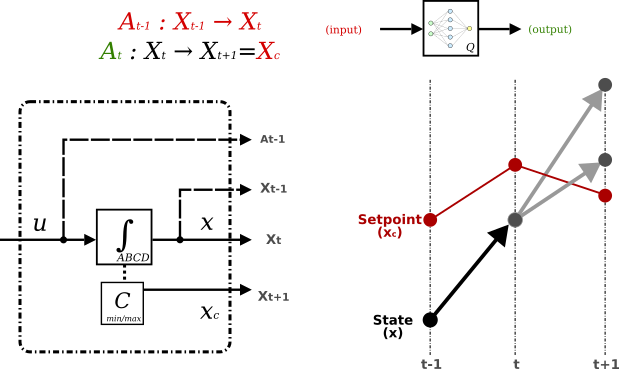


Nous obordons ici les premiers entrainement et test pour étudier la convergence de l'algorithme d'apprentissage sur notre modele d'environnement :

1.   Valeurs constante 1/2 tout au long de l'entrainement
2.   Valeurs constante variable / episodes
3.   Valeurs variables par épisodes

Les métriques sont {loss & n_epsiode de convergence & recompense cumulé}

Ensuite on compare l'efficacité pour chacun des cas spécifique, l'objectif est de s'avoir lequel généralise le plus.

On utilise l'algorithme DQN pour avoir un schéma d'équivalence avec Tout ou rien "modifié". En effet, nous considèrons que nous pouvons utiliser une approche naive pour controler un systeme linéaire avec ces informations, tel que l'action suivante peut s'ecrire quelquesoit $t$ :

$$a_{t} = sgn(a_{t-1}) \cdot sgn(s_{t} - s_{t-1}) \cdot sgn(s_{c, t+1} - s_{t})$$

> (en reflexion)



Ici, nous utilisons RLlib plutot que TorchRL car il est a ce jour plus abouti. Nous ne testerons pas les décisions transformer, mais des modèles *Transformers* et *RNN* sont inclus dans RLlib. Nous utiliserons ainsi des architectures LSTM et *GTrXL* pour tester par la suite.

In [1]:
!pip3 install control --quiet
!pip3 install gymnasium --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.8 MB/s eta 0:00:00


In [2]:
import pylab as plt

*(masquer cette partie)*

---

## Code de l'environement

In [3]:
import gymnasium as gym
import numpy as np, control as ct
import pandas as pd
import scipy.ndimage as sm
import scipy.optimize as so

from tqdm import tqdm

from gymnasium import spaces

class LinearSystemControl(gym.Env):
    def __init__(self, config={
                  "env_mode":1,
                  "update_setpoint":True,
                  "reset_X_start":True,
                  "tf":None,
                  "reset":True,
                  "isdiscrete":False,
                  "SpaceState":None,
                  "setpoint":None,
                  "env_config":None,
                  "modular":False,
                  "return_action":True,
                  "return_speed":False,
                  "order":3,
                  "t":10,
                  "N":250}
                 ):
        self.lti_config = config
        self.mode = config["env_mode"]
        self.definedSet = config["setpoint"]
        self._order = config["order"]
        self._isdiscrete = config["isdiscrete"]
        self._update_setpoint = config["update_setpoint"]
        self._reset = config["reset"]
        self._return_action = config["return_action"]
        self._reset_start = config["reset_X_start"]
        self._return_speed = config["return_speed"]
        self._rotate = config["modular"]
        self._max_episode_steps = config["N"]
        self.T = config["t"]
        # first action
        self.U = list(np.random.randint(-1,2,2))
        # sim
        self._elapsed_steps = 0
        self._life = 3
        self.previous_action = 0.
        # parameter
        if self._isdiscrete :
            self.action_space = spaces.Discrete(3)  # {-1, 0, 1}
        else :
            self.action_space = spaces.Box(low=-1., high=1., shape=(1,), dtype=np.float32) # [-1;1]
        self.dim_obs = 4 if self._return_action else 3
        # StateSpace
        self.ss = pd.Series({"i":0, "s":0, "A":np.array(1), "B":np.array(1), "C":np.array(1), "D":np.array(1)})  if not(isinstance(config["SpaceState"], pd.Series)) else config["SpaceState"]
        # IOSystem U={0,1}, X0=1
        self.dydt = []
        self.X_start = 0. #only the first
        self.time = np.linspace(0, self.T, self._max_episode_steps)
        if config["tf"] == None :
          self.sys = self.define_LinearIO(self.ss)
        else :
          self.sys = self.generate_ss_from_tf(*config["tf"])
        # define setpoint
        self.set_setpoint()

    ############ Parameter Part
    def signal_generator(self, N, epsilon=0.05):
        a = (1 - 2*epsilon)
        # smoother
        s = np.random.randint(1,N//10)
        # random
        r = np.random.random(N)
        # smooth signal
        smooth = sm.gaussian_filter1d(r, s)
        n = a*(smooth - smooth.min())/(smooth.max() - smooth.min()) + epsilon
        return n

    def set_setpoint(self, epsilon=0.05):
        # mode : consigne (setpoint in  [0+a,1-a])
        if self.mode == 0 :
            if self.definedSet == None :
              self.setpoint = (self.setmin + self.setmax)/2.
            else :
              self.setpoint = self.definedSet
        elif self.mode == 1 :
            self.setpoint = np.random.uniform(self.setmin + 2*self.D, self.setmax - 2*self.D)
        else :
            consigne = self.signal_generator(self._max_episode_steps, epsilon=self.D) # def pour nb max iter
            self.all_setpoint = (self.setmax - self.setmin)*consigne + self.setmin
            self.setpoint = self.all_setpoint[self._elapsed_steps] # prends la derniere valeur

    def define_Boundary(self, sys, d=0.05) :
        # calculate boundary
        _, Y_g = ct.forced_response(sys, self.time, U=-1, X0=self.X_start)
        _, Y_h = ct.forced_response(sys, self.time, U=1, X0=self.X_start)
        # sign in limit --> for order sup 1, find zeros bounds for generalization (zeros = len(fsolve(Y_g - Y_h, [0, self._max_episode_steps])))
        self.sign = (1. if Y_h[-1] > Y_g[-1] else -1.)
        # boundary
        self.min, self.max = min(Y_g.min(), Y_h.min()), max(Y_g.max(),Y_h.max())
        # setpoint limit (squeeze theroem : g < f < h) --> NO
        self.setmin, self.setmax = min(np.median(Y_h), np.median(Y_g)), max(np.median(Y_h), np.median(Y_g))
        # apply
        #self.observation_space = spaces.Box(low=self.min, high=self.max, shape=(self.dim_obs,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.dim_obs,), dtype=np.float32)
        # basic error 10 %
        self.D = d*(self.setmax - self.setmin)

    ############ Model Part
    def generate_ss_from_tf(self, tf=[([1],[1,1]), ([-1],[1,1])], setpoint=1./2):
        # extract ft & sp
        if isinstance(tf, tuple):
          tf_ = tf
          num , den = tf_
        else :
          tf_ = tf[np.random.randint(len(tf))]
          if tf_[0] != "rss" :
            num , den = tf_
        self.setpoint = self.definedSet = setpoint
        # create system
        if tf_[0] == "rss" :
          sys = ct.rss(tf_[1])
          if self.mode == 0 : print('[WARNING] Incorrect mode if rss')
        else :
          if isinstance(num, str) :
            num = np.random.choice([-1,1])*(.1+.9*np.random.random())
          sys = ct.TransferFunction(num,den)
          sys = ct.tf2ss(sys)
        # start
        if self._reset_start :
          self.X_start = np.random.choice([-1.,0.,1.])
        # extract parameter
        self.ss["A"], self.ss["B"], self.ss["C"], self.ss["D"] = sys.A, sys.B, sys.C, sys.D
        self.ss["i"], self.ss["s"] = 1, sys.nstates
        # bound and simulation parameter
        self.define_Boundary(sys)
        # save
        self._order = self.ss["s"]
        return sys

    def define_LinearIO(self, ss, d=0.05):
        if ss.i == 0 :
          ss["s"] = self._order
          sys = ct.rss(self._order)
          ss["A"], ss["B"], ss["C"], ss["D"] = sys.A, sys.B, sys.C, sys.D
        else :
          sys = ct.StateSpace(ss.A,ss.B,ss.C,ss.D)
          self._order = ss["s"]
        if self._reset_start :
          self.X_start = np.random.choice([-1.,0.,1.])
        # bound and simulation parameter
        self.define_Boundary(sys, d)
        return sys

    ############ Simulation Part
    def reset(self, seed=None, options=None):
        self._life = 3
        self._elapsed_steps, T = 0, self.time[0:2]
        # re-init
        if self._reset :
          if self.lti_config["tf"] == None :
            self.sys = self.define_LinearIO(self.ss)
          else :
            self.sys = self.generate_ss_from_tf(*self.lti_config["tf"])
        if self._update_setpoint :
          self.set_setpoint()
        # 1st step
        self.U = list(np.random.randint(-1,2,2))
        T, Y, X = ct.forced_response(self.sys, T, U=self.U, X0=self.X_start, return_x=True)
        self.V = self.U
        # update
        self._elapsed_steps += 1
        self.X = X[:,1]
        self.previous_action = self.U[-1]
        #return <obs>
        if self._return_speed :
          self.dydt = [(Y[1] - Y[0]) / (T[1] - T[0])]
          obs = [[Y[0],self.dydt[0]],[Y[1],self.dydt[0]],[self.setpoint,0]]
          if self._return_action :
            obs = [[self.previous_action, 0]] + obs
        else :
          obs = [Y[0], Y[1], self.setpoint]
          if self._return_action :
            obs = [self.previous_action] + obs
        return np.array(obs), {}

    def step(self, action):
        done = False
        # continuous or discrete
        if self._isdiscrete :
            action = action - 1 # {0,1,2} --> {-1, 0, 1}
        else :
            action = float(action)
            if self._rotate :
              action = 1.5*np.sin(action)
            else :
              action = min(max(action,-1.5),1.5)
        # update input
        T = self.time[self._elapsed_steps:self._elapsed_steps+2]
        self.V = [self.V[-1], action]
        # calculate
        T, Y, X = ct.forced_response(self.sys, T, U=self.V, X0=self.X, return_x=True)
        # update output
        self._elapsed_steps += 1
        self.X = X[:,1]
        # reward : Custom reward with HubberLoss (setpoint(t))
        if Y[-1] > (self.setpoint - self.D/5.) and Y[-1] < (self.setpoint + self.D/5.) :
            reward = 1.
        elif Y[-1] > (self.setpoint - self.D) and Y[-1] < (self.setpoint + self.D) :
            reward = 0.5
        else :
            reward = 0.
        # outlimit
        if (Y[-1] < self.min) or (Y[-1] > self.max) :
            reward = -1.
            self._life -= 1.
            if self._life == 0 :
              reward = -10.
              done = True
        # limit
        if self._elapsed_steps == self._max_episode_steps - 1 :
            done = True
        # update setpoint
        setpoint = self.setpoint
        if self.mode == 2 :
          self.setpoint = self.all_setpoint[self._elapsed_steps]
        # new state (setpoint(t+1))
        if self._return_speed :
          self.dydt = [self.dydt[-1]] + [(Y[1] - Y[0]) / (T[1] - T[0])]
          dsdt = (self.setpoint - setpoint) / (T[1] - self.time[self._elapsed_steps])
          obs = [[Y[0],self.dydt[0]],[Y[1],self.dydt[1]],[self.setpoint, dsdt]]
          if self._return_action :
            dadt = (action - self.previous_action) / (T[1] - self.time[self._elapsed_steps])
            obs = [[action, dadt]] + obs
        else :
          obs = [Y[0], Y[1], self.setpoint]
          if self._return_action :
            obs = [action] + obs
        state = np.array(obs)
        # update action
        self.previous_action = action
        # return <obs>, <reward: float>, <done: bool>, <info: dict>
        info = {}
        return state, reward, done, done, info

Pour un guide d'utilisation de RLlib, voir le lien suivant : https://docs.ray.io/en/latest/rllib/rllib-training.html

*(masquer cette partie)*

---

## Test


In [4]:
od1pn_config_m2_dqn = {
    "env_mode":2,
    "update_setpoint":True,
    "reset_X_start":True,
    "reset":True,
    "isdiscrete":True, #False
    "SpaceState":None,
    "tf": ([('a',[1,1]), ('rss',2)],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":3,
    "t":10,
    "N":250
}

od1pn_config_m1_dqn = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":True,
    "reset":True,
    "isdiscrete":True, #False
    "SpaceState":None,
    "tf": ([([1],[1,1]),('a',[1,1]), ('rss',2)],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":3,
    "t":10,
    "N":250
}

### Tout-ou-Rien "généralisé naïf"

In [5]:
# Create the Gym environment
#env = LinearSystemControl(lti1_config_m1_ppo)
#env = LinearSystemControl(lti1_config_m2_ppo)
env = LinearSystemControl(od1pn_config_m1_dqn)
#env = LinearSystemControl(od1_config_m0_dqn)
#env = LinearSystemControl(od1n_config_m0_dqn)
# see Order 1
print(env.sys)
# verif
_ = env.reset()
env.sys

A = [[-1.]]

B = [[1.]]

C = [[-0.62936579]]

D = [[0.]]



StateSpace(array([[-1.]]), array([[1.]]), array([[1.]]), array([[0.]]))

**Rappel :**
$$a_{t} = sgn(a_{t-1}) \cdot sgn(s_{t} - s_{t-1}) \cdot sgn(s_{c, t+1} - s_{t})$$


[-1.         -2.01084767  2.31900846 -3.60811842] 248 2.0


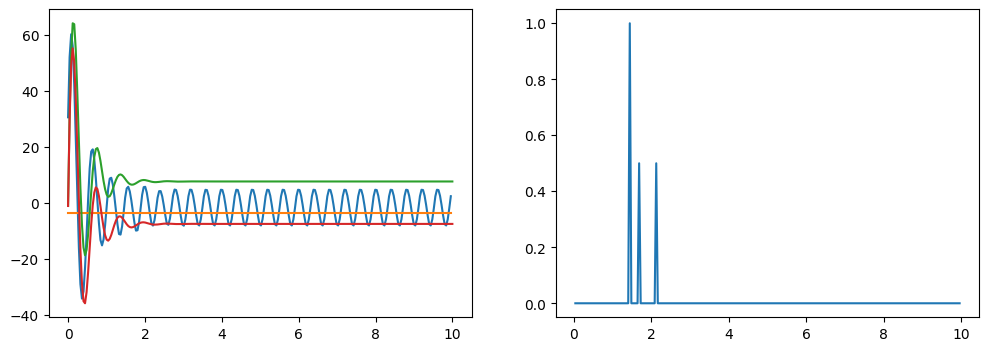

<LinearIOSystem:sys[6]:['u[0]']->['y[0]']>

In [6]:
# mode
random = False
perturb = True
# simulation
state, _ = env.reset()
Y = [state[2:]]
R = []
for i in range(env._max_episode_steps-2) :
  if random :
    action = env.action_space.sample()
  else :
    #action = np.sign(state[0])*np.sign(state[2]-state[1])*np.sign(state[3]-state[2]) + env._isdiscrete
    action = env.sign*np.sign(state[3]-state[2]) + env._isdiscrete # boolean ToR (sliding mode 1)
  if perturb :
    if np.random.random() > 0.999 :
      action = env.action_space.sample()
  state, reward, done, _, info = env.step(action)
  Y += [state[2:]]
  R += [reward]
  if done : break
print(state, len(R), np.sum(R))
# compare
T_OUT, Y_p = ct.forced_response(env.sys, env.time, U=1, X0=env.X_start)
T_OUT, Y_m = ct.forced_response(env.sys, env.time, U=-1, X0=env.X_start)
# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(T_OUT[:len(Y)], Y); axs[0].plot(T_OUT, Y_p)
axs[0].plot(T_OUT, Y_m); axs[1].plot(T_OUT[1:len(Y)], R)
plt.show()
env.sys

## ToR stat

In [16]:
import seaborn as sns

In [70]:
lti_config_tf1_mX_algo = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":True,
    "reset":True,
    "isdiscrete":True, #False
    "SpaceState":None,
    #"tf": (('rss',1),1./2), #None
    "tf": ([('a',[1,1]), ('rss',1)],1./2), #None
    #"tf": (('a',[1,1]),1./2), #None
    #"tf": (([1],[1,1]),1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":3,
    "t":10,
    "N":250
}

In [71]:
env = LinearSystemControl(lti_config_tf1_mX_algo)
columns = ["eps","action-1","state-1","state","state_c","action","reward"]
data = []
# 100 simulation (episode)
for e in tqdm(range(100)):
  state, _ = env.reset()
  # loop
  for i in range(env._max_episode_steps-2) :
    action = env.sign*np.sign(state[3]-state[2]) + env._isdiscrete
    state, reward, done, _, info = env.step(action)
    # extract data
    data += [[e] + list(state) + [action, reward]]
    if done: break
# save dataframe
df = pd.DataFrame(data, columns=columns)
df.head()

100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


,eps,action-1,state-1,state,state_c,action,reward
0,0,-1.0,0.163350,0.145203,-1.039204,0.0,0.0
1,0,-1.0,0.145203,-0.031875,-1.039204,0.0,0.0
2,0,-1.0,-0.031875,-0.192211,-1.039204,0.0,0.0
3,0,-1.0,-0.192211,-0.337388,-1.039204,0.0,0.0
4,0,-1.0,-0.337388,-0.468840,-1.039204,0.0,0.0


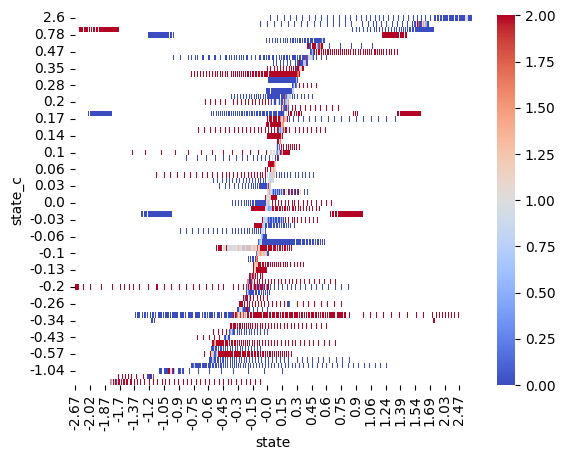

In [72]:
df_reduce = df.round(2)
data = df_reduce.pivot_table(index='state_c', columns='state', values='action', aggfunc="mean")
data = data.loc[::-1,:]
sns.heatmap(data, cmap='coolwarm')
plt.show()

In [74]:
df_sum = df.groupby(["eps"], as_index=False)['reward'].sum()
df_sum.divide(249).describe()

,eps,reward
count,100.000000,100.000000
mean,0.198795,0.656205
std,0.116512,0.218786
min,0.000000,-0.048193
25%,0.099398,0.623996
50%,0.198795,0.700803
75%,0.298193,0.778112
max,0.397590,0.983936
